In [1]:
import os
from itertools import chain, repeat, compress
from pathlib import Path

import autoreject
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from autoreject import get_rejection_threshold
from scipy.integrate import simpson
from Settings import *
from utils import *

In [2]:
mne.set_log_level(False)
try:
    mne.cuda.init_cuda(verbose=True)
    mne.utils.set_config('MNE_USE_CUDA', 'true') 
finally:
    cuda=True


plt.rcParams.update({'figure.max_open_warning': 0})

#all ICAs to compute
icas = []
clean_raws = {}

Now using CUDA device 0
Enabling CUDA with 5.07 GB available memory


In [3]:
lstPIds = []
path = "../Data/"
for filename in os.listdir(path):
    if filename.endswith(".csv"): 
        lstPIds.append(int(filename.split("-")[0].replace("ID", "")))
    else:
        continue
lstPIds = list(set(lstPIds))
print(lstPIds)
print(str(len(lstPIds)) + " subjects")

if TEST:
    lstPIds = [1, 2]
    lstPIds = list(set(lstPIds))
    NUM_BLOCKS = 2

[1, 2, 3, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
17 subjects


In [4]:
arr_raws = []

dir_path = r'./fifs/'

Path(dir_path).mkdir(parents=True, exist_ok=True)
Path('./ica/fifs').mkdir(parents=True, exist_ok=True)
Path('./pickles').mkdir(parents=True, exist_ok=True)
Path('./ica/epochs').mkdir(parents=True, exist_ok=True)
Path('./Plots/ICA').mkdir(parents=True, exist_ok=True)
Path('./Plots/NoICA').mkdir(parents=True, exist_ok=True)


if len(os.listdir('./fifs')) != NUM_BLOCKS * len(lstPIds):
    for pid in tqdm.tqdm(lstPIds):

        dfState = pd.read_csv(f"{path}ID{pid}-state.csv")
            
        dfEEG = pd.read_csv(f"{path}ID{pid}-EEG.csv")
        dfEEG.rename(columns={"Value0": "F3", "Value1": "C3", "Value2": "P3", "Value3": "P4", "Value4": "C4", "Value5": "F4", "Value6": "Pz"}, inplace=True)
        dfEEG.drop("TimeLsl", axis =1, inplace=True)

        dstate = pd.read_csv(f"{path}ID{pid}-state.csv")

        dfAll = pd.merge(dfEEG, dstate, on =["Time"], how="outer")
        dfAll.sort_values(by="Time", inplace=True)

        dfAll = dfAll.drop(columns=["Value7","AdaptationStatus", "NBackN", "State"] )
        dfAll.fillna(method='ffill', inplace=True)
        dfAll.drop(dfAll[dfAll.BlockNumber < 0].index, inplace=True)
        dfAll.dropna(inplace=True)
            

        for x in range(1, NUM_BLOCKS+1):  
            
            # Prepare data 
            data = dfAll.loc[dfAll['BlockNumber'] == x]
            df = pd.DataFrame(data)

            info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
            info.set_montage('standard_1020',  match_case=False)

            samples = df.T
            
            raw = mne.io.RawArray(samples, info)
            raw.drop_channels(['Time', 'BlockNumber'])
            
            #remove power line interferance
            raw.notch_filter(50., n_jobs=-1)
            
            #high pass filter to remove slow drifts, 70 Hz low pass
            raw.filter(1., 70., None, fir_design='firwin')
            
            # set eeg reference
            raw.set_eeg_reference('average', projection=True)
            
            # Visual inspection of bad channels
            # TODO, empty list for now. With new setup, check for bad channels only once for all blocks.
            raw.info['bads'] =  bads[pid-1][x-1]
            if raw.info['bads'] != []:
                raw.interpolate_bads()   
            
            #arr_raws.append(raw)
            raw.save('./fifs/' + str(pid) + '-' + str(x) + '_eeg.fif', overwrite = False)

In [5]:
exclude_ic = [] # TODO sure its here?
action = None

for pid in tqdm.tqdm(lstPIds):
    
    # don't ask for input for all participants
    if action == 'no':
        pick_ic_as_template = False
    else:
        if pick_ic_as_template:
            action = get_user_input(valid_response={'no', 'yes'},
                        prompt="Select ICs for ICE corrmap? - yes | no", 
                        err_prompt="Type  \"yes\" or \"no\": \n")
            
        if action == 'no':
            pick_ic_as_template = False
    
    for x in range(1, NUM_BLOCKS+1):  
        
        raw = mne.io.read_raw_fif('./fifs/' + str(pid) + '-' + str(x) + '_eeg.fif', preload=True)
          
        # independent component analysis (ICA)                
        if len(os.listdir('./ica/fifs/')) != NUM_BLOCKS * len(lstPIds):
        #if(True):
            
            # independent component analysis (ICA)
            ica = mne.preprocessing.ICA(method="infomax",random_state = 97)
            
            # make one second epochs for ICA fit
            # later apply to raw data
            epochs = mne.make_fixed_length_epochs(raw.copy(), preload=True, duration = epochs_tstep)

            local_autoreject = False
            if local_autoreject:
                ar = autoreject.AutoReject(n_jobs=-1,  verbose=True, random_state=11)
                epochs_clean, reject_log = ar.fit_transform(epochs, return_log=True) 
                reject_log.plot('horizontal')
                evoked_bad = epochs[reject_log.bad_epochs].average()
                plt.figure()
                plt.plot(evoked_bad.times, evoked_bad.data.T * 1e6, 'r', zorder=-1)
                epochs_clean.average().plot(axes=plt.gca())
                #epochs = epochs_clean
                ica.fit(epochs[~reject_log.bad_epochs], tstep = epochs_tstep)
            else : 
                reject = get_rejection_threshold(epochs, ch_types = 'eeg', verbose=False)
                #print("The rejection dictionary is %s " %reject)
                epochs.drop_bad(reject=reject)
                ica.fit(epochs, tstep=epochs_tstep)
        
            ica.save('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif', overwrite = True)
            epochs.save('./ica/epochs/' + str(pid) + '-' + str(x) + '-epo.fif', overwrite = True)
          
        else:
            ica = mne.preprocessing.read_ica('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif')
            epochs = mne.read_epochs('./ica/epochs/' + str(pid) + '-' + str(x) + '-epo.fif', preload=True)
            
        # Optionally autoreject muscle and eog artifacts
        if (pick_ic_auto):
            #start fresh, else find_bads_muscle fails
            ica.exclude = []
            
            ica_z_thresh = 1.96
            eog_indices, eog_scores = ica.find_bads_eog(raw, 
                                                        ch_name=['F3', 'F4'], 
                                                        threshold=ica_z_thresh)
            
            muscle_idx_auto = []
            #TODO make true again, just not with  this data...
            if(True):
                muscle_idx_auto, scores = ica.find_bads_muscle(raw)
                ica.plot_scores(scores, exclude=muscle_idx_auto)
                
                ica.exclude = eog_indices
                ica.plot_scores(eog_scores)  
                ica.plot_overlay(raw, exclude=eog_indices, picks='eeg', title = str(pid) + '-' + str(x), start = 20., stop=360. )

                ica.plot_overlay(raw, exclude=muscle_idx_auto, picks='eeg', title = str(pid) + '-' + str(x), start = 20., stop=360. )

                ica.exclude = muscle_idx_auto
                print(f'Automatically found muscle artifact ICA components: {muscle_idx_auto}')
                ica.plot_overlay(raw, exclude=muscle_idx_auto, picks='eeg', title = str(pid) + '-' + str(x), start = 20., stop=360. )
            
            for item in muscle_idx_auto + eog_indices :
                if item not in ica.exclude:
                    ica.exclude.append(item)
        
        # Optionally pick templates for corrmap
        if(pick_ic_as_template):                
            done = False
            
            while not done: 
                
                ics_old = ica.exclude
                #ica.plot_properties(epochs, dB=True, log_scale= True, psd_args={'fmax':70})
                #ica.plot_properties(epochs, dB=True, log_scale= True)
                ica.plot_sources(raw, block = True, title = str(pid) + '-' + str(x) )
                ica.plot_overlay(raw, exclude=ica.exclude, picks='eeg', title = str(pid) + '-' + str(x), start = 20., stop=360. )

                while True:
                    accept = get_user_input(valid_response={'no', 'yes'},
                                            prompt="Accept? - yes | no",
                                            err_prompt = "yes | no")
                    try:
                        if accept == 'yes':
                            exclude_ic = ica.exclude
                            ica.save('./ica/'+ str(pid) + '-' + str (x) + '_template-ica.fif', overwrite = True)
                            ica.save('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif', overwrite = True)
                            done = True
                            quit = get_user_input(valid_response={'no', 'yes'},
                                            prompt="Quit? - yes | no",
                                            err_prompt = "yes | no")
                            if quit == 'yes':
                                pick_ic_as_template = False
                                break
                            break
                        else:
                            ica.exclude = ics_old # doesn't to anything
                            quit = get_user_input(valid_response={'no', 'yes'},
                                            prompt="Quit? - yes | no",
                                            err_prompt = "yes | no")
                            if quit == 'yes':
                                pick_ic_as_template = False
                                done = True
                                break     
                            else:
                                break              
                    except Exception as e:
                        print(e)
                                
        #TODO put this somewhere else
        clean_ica_excludes = False
        if(clean_ica_excludes):
            ica.exclude = []
            ica.save('./ica/fifs/' + str(pid) + '-' + str(x) + '-ica.fif', overwrite = True)

        icas.append(ica)
        arr_raws.append(raw)

        # raw.save("./ica/pipeline_1/raw/"+str(pid)+"_"+str(x)+".fif")

100%|██████████| 17/17 [00:04<00:00,  3.87it/s]


In [6]:
ica_templates = []

dir_path = r'./ica/'
for path in os.scandir(dir_path):
    if path.is_file():
        ica_template = mne.preprocessing.read_ica(dir_path  + path.name)
        if(ica_template.exclude != []):           
            ica_templates.append(ica_template)
        else:
            os.remove(dir_path + path.name)
            
clean_raws = np.zeros((len(lstPIds), NUM_BLOCKS),dtype=object)

for n, ic_templ in enumerate(ica_templates):
    icas.insert(0,ic_templ) #first element of ica array is the template
    for x, excl in enumerate(ica_templates[n].exclude):
        print(ica_templates[n].exclude)
        #mne.preprocessing.corrmap(icas, [0,excl], label='exclude', threshold = 0.9, plot=False)
        mne.preprocessing.corrmap(icas, [0,excl], label='exclude',  plot=False)

    icas.pop(0) # remove template.

p = 0
b = 0
for i, ica in enumerate(icas):
    b += 1
    p = p + 1 if i % 7 == 0 else p
    if p == 4: p = 5 
    if p == 8:  p = 9
    if p == 10: p = 11
    b = 1 if  b == 8 else b

    # add excluded ICs from corrmap to ica.exclude
    if 'exclude' in ica.labels_:        
        
        #add autodetected artifacts to exclude  
        if(pick_ic_auto):
            for item in  ica.labels_['exclude'] :
                if item not in ica.exclude:
                    ica.exclude.append(item)
        else:
            ica.exclude = ica.labels_['exclude']
    # else:
    #     print("No templates selected \n")
            
    #n.plot_overlay(arr_raws[i], n.exclude, picks='eeg',  title=("Pid "+ str(p) +" block " +str(b)), stop = 360.)
    ica.apply(arr_raws[i]) # TODO at least i hope so, double check indices

# for whatever reason i cant convert the arr_raws array to numpy to do the reshape :D 
# i could look into it. later.
for i in range(len(lstPIds)):
    for j in range(NUM_BLOCKS):
        clean_raws[i][j] = arr_raws[j%NUM_BLOCKS+i*NUM_BLOCKS]

# TODO save preprocessed raws        
#raw.save("./ica/pipeline_1/raw/"+str(pid)+"_"+str(x)+".fif")

In [7]:
pws_lst = list()
for n, pid in enumerate(tqdm.tqdm(lstPIds)):
    
    for x in range(1,NUM_BLOCKS+1):
        
        raw = clean_raws[n][x-1]

        #plot alpha and theta 
        if(plot_plots):
            
            fig = plt.figure( figsize=(7, 3))
            subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[3., 1.])
            axs0 = subfigs[0].subplots(2, 1)
            subfigs[0].set_facecolor('0.9')

            raw.compute_psd(method='multitaper', fmin=bands.theta[0], fmax = bands.theta[1]).plot(dB=False, axes = axs0[1], show = False)
            raw.compute_psd(method='multitaper', fmin=bands.alpha[0], fmax = bands.alpha[1]).plot(dB = False, axes = axs0[0], show = False) 
        
            axs1 = subfigs[1].subplots(2, 1)
            raw.compute_psd(method='multitaper', fmin=bands.theta[0], fmax = bands.theta[1]).plot_topo(dB = False, axes = axs1[0], show = False)
            raw.compute_psd(method='multitaper', fmin=bands.alpha[0], fmax = bands.alpha[1]).plot_topo(dB = False, axes = axs1[1], show = False)
            
            fig.set_constrained_layout(True)
            fig.suptitle("PID " + str(pid) + " block " + str(x))
            if(save_plots):
                filepath = "../Plots/PID_" + str(pid) + "-Block_" + str(x)  + "-raw_psd_topo.png"
                plt.savefig(filepath)
 
        ### Compute the power spectral density (PSD)
                
        for grp_nr in range(len(channel_groups)):
            
            #pick channels for different frequencies
            picks = mne.pick_types(raw.info, eeg=True)
            picks_alpha = mne.pick_types(raw.info, eeg=True, exclude=mask_channels(channel_groups[grp_nr][0]))
            picks_theta = mne.pick_types(raw.info, eeg=True, exclude=mask_channels(channel_groups[grp_nr][1]))

            for m, method in enumerate(methods):
                njob = "cuda" if cuda else -1
                n_jobs = njob if method != 'welch' else 2 #NOTE: this is a bug in NME, welch with raw does not support using all cpus
                
                psds, freqs = get_psd(raw.copy(), method, picks, n_jobs) 
                # psds /= np.sum(psds, axis=-1, keepdims=True) 
                psds_mean = psds.mean(0)
                freq_res = freqs[1] - freqs[0]
                
                psds_alpha, freqs_alpha = get_psd(raw.copy(), method, picks_alpha,n_jobs)  
                psds_mean_alpha = psds_alpha.mean(0)
                freq_res_alpha = freqs_alpha[1] - freqs_alpha[0]
                
                psds_theta, freqs_theta = get_psd(raw.copy(), method, picks_theta,n_jobs)            
                psds_mean_theta = psds_theta.mean(0)
                freq_res_theta = freqs_theta[1] - freqs_theta[0]
                
                # Find intersecting values in frequency vector
                idx_alpha = np.logical_and(freqs_alpha >= bands.alpha[0], freqs_alpha <= bands.alpha[1])
                idx_theta = np.logical_and(freqs_theta >= bands.theta[0], freqs_theta <= bands.theta[1])      
            
                # absolute power
                bp_alpha = simpson(psds_mean_alpha[idx_alpha], dx=freq_res_alpha)
                bp_theta = simpson(psds_mean_theta[idx_theta], dx=freq_res_theta) 
                bp_total = simpson(psds_mean, dx=freq_res)
                
                # relative power
                bp_alpha_rel =  bp_alpha / bp_total # alpha relative power
                bp_theta_rel = bp_theta / bp_total # theta relative power

                alpha_theta_total = bp_alpha / bp_theta
                alpha_theta_rel = bp_alpha_rel / bp_theta_rel       
                
                #peak power at freq
                peak_alpha = freqs_alpha[np.argmax(psds_mean_alpha[idx_alpha])]
                peak_theta = freqs_theta[np.argmax(psds_mean_theta[idx_theta])]
                
                if(plot_plots):

                    fig, axes = plt.subplots(2, 2, figsize=(7, 3))
                    for ind, (label, band_def) in enumerate(bands):
                        
                        # Create a topomap for the current oscillation bandca
                        raw.compute_psd(method=method).plot_topomap({label: band_def}, ch_type='eeg', cmap = 'viridis', show_names=True, normalize=True, axes=axes[0, ind], show=False)

                        idx = np.logical_and(freqs >= band_def[0], freqs <=  band_def[1])
                        axes[0,ind].set_title(method + " PSD topo " + label + ' power ' + str(channel_groups[grp_nr]), {'fontsize' : 7})

                        psds_std = (psds_mean[idx]).std(0)
                        peak = freqs[np.argmax(psds_mean[idx])]
                        axes[1,ind].plot(freqs[idx], psds_mean[idx], color='k')
                        axes[1,ind].fill_between(freqs[idx], psds_mean[idx] - psds_std, psds_mean[idx] + psds_std,
                                        color='k', alpha=.5)
                        axes[1,ind].set_title(method + " PSD " + label + ' power', {'fontsize' : 7})
                    
                    fig.suptitle("PID " + str(pid) + " block " + str(x) + " " + str(channel_groups[grp_nr]))
                    fig.set_constrained_layout(True)
                    
                    if(save_plots):
                        filepath = "../Plots/PID_" + str(pid) + "-Block_" + str(x) + "-Group_" + str(grp_nr) + ".png"
                        plt.savefig(filepath)
            
                pws_lst.append([pid, x, bp_alpha, bp_theta, alpha_theta_total, grp_nr, method])
                   
        if(draw_plots):

            plt.show()

100%|██████████| 17/17 [07:17<00:00, 25.74s/it]


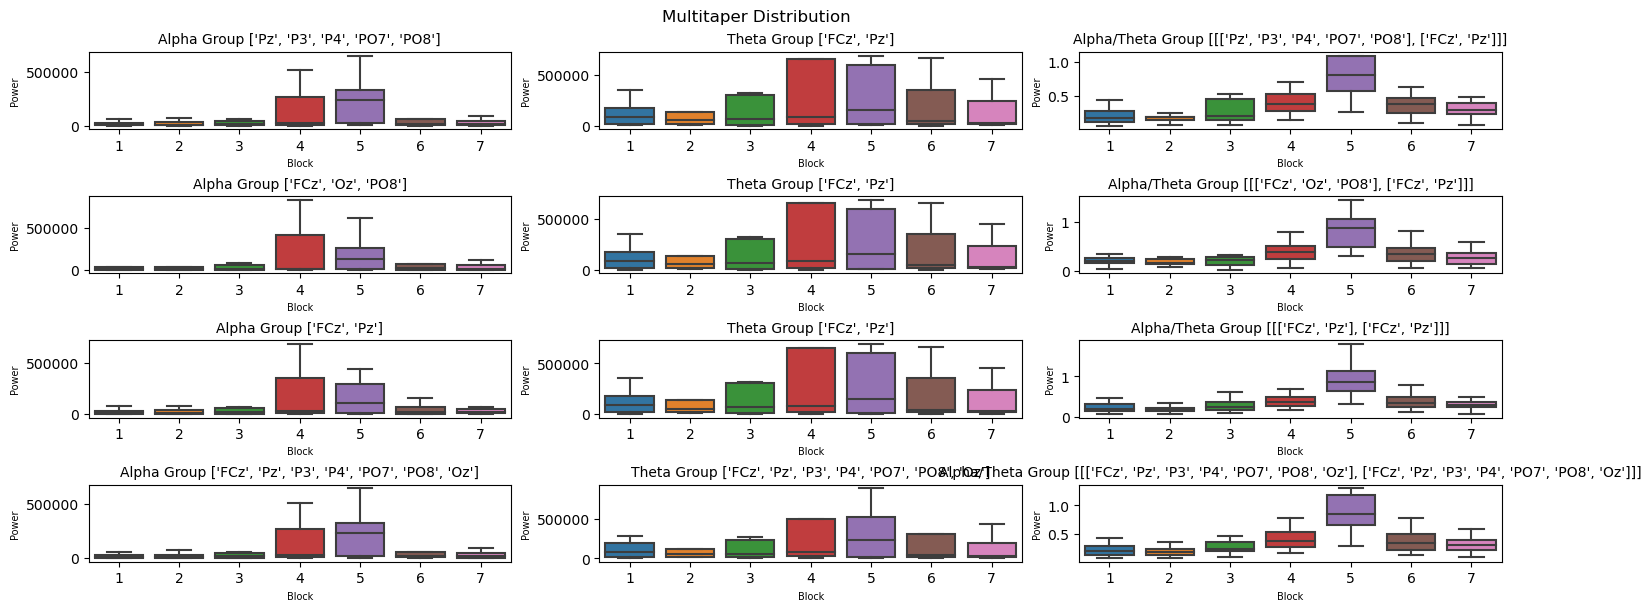

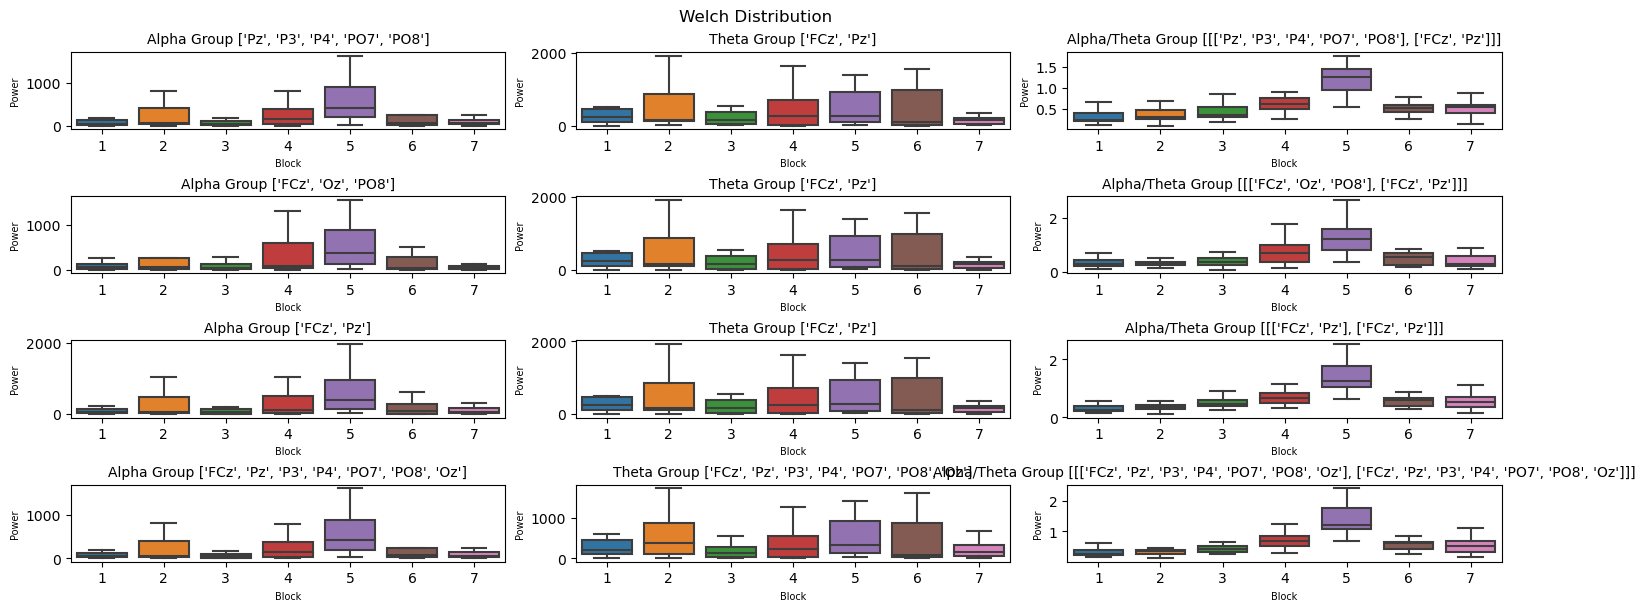

In [8]:
n_ch_grps = len(channel_groups)
calc_powers = ['Alpha', 'Theta', 'Alpha/Theta']

f, axes = plt.subplots(n_ch_grps, len(calc_powers), figsize=(15,6), constrained_layout=True, squeeze=False)
dfPowers = pd.DataFrame(pws_lst, columns =['PID', 'BlockNumber', 'Alpha', 'Theta', 'Alpha/Theta', 'Group', 'Method'])
ax_idx = 1 if len(axes) > 1 else 0

for ch_grp in range(n_ch_grps):
    for calc_power, ax1 in enumerate(axes[ax_idx]):
        sns.boxplot(x = "BlockNumber", y = calc_powers[calc_power], data = dfPowers.loc[(dfPowers['Group'] == ch_grp) & (dfPowers['Method'] == 'multitaper')], ax=axes[ch_grp,calc_power],showfliers=False)
        sns.stripplot(x="BlockNumber", y = calc_powers[calc_power], data=dfPowers.loc[(dfPowers['Group'] == ch_grp) & (dfPowers['Method'] == 'Multitaper')], marker="o", alpha=0.3, color="black", ax=axes[ch_grp,calc_power])
        axes[ch_grp,calc_power].set_title( str(calc_powers[calc_power]) + " Group " + str(channel_groups[ch_grp][calc_power]), fontsize=10)
        axes[ch_grp,calc_power].set_ylabel('Power', fontsize=7)
        axes[ch_grp,calc_power].set_xlabel('Block', fontsize=7)
f.suptitle("Multitaper Distribution")

f, axes = plt.subplots(n_ch_grps, len(calc_powers), figsize=(15,6), constrained_layout=True, squeeze=False)
ax_idx = 1 if len(axes) > 1 else 0

for ch_grp in range(n_ch_grps):
    for calc_power, ax1 in enumerate(axes[ax_idx]):
        sns.boxplot(x = "BlockNumber", y = calc_powers[calc_power], data = dfPowers.loc[(dfPowers['Group'] == ch_grp) & (dfPowers['Method'] == 'welch')], ax=axes[ch_grp,calc_power],showfliers=False)
        axes[ch_grp,calc_power].set_title( str(calc_powers[calc_power]) + " Group " +  str(channel_groups[ch_grp][calc_power]), fontsize=10)
        axes[ch_grp,calc_power].set_ylabel('Power', fontsize=7)
        axes[ch_grp,calc_power].set_xlabel('Block', fontsize=7)
f.suptitle("Welch Distribution")

plt.show()

In [9]:
dfPowers.to_pickle('./pickles/dfPowers.pickle')